# Face Detection and Blurring

Using Kornia library to detect faces using both CPU/GPU.

In [23]:
import io

import requests

def download_image(url: str, filename: str = "") -> str:

    filename = url.split("/")[-1] if len(filename) == 0 else filename

    # Download

    bytesio = io.BytesIO(requests.get(url).content)

    # Save file

    with open(filename, "wb") as outfile:

        outfile.write(bytesio.getbuffer())


    return filename


url = "https://raw.githubusercontent.com/kornia/data/main/crowd.jpg"

download_image(url)

'crowd.jpg'

In [3]:
import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch

from kornia.contrib import FaceDetector, FaceDetectorResult

# select the device and type

device = torch.device("cpu")  # use 'cuda:0'

dtype = torch.float32

In [4]:
# load the image (face detector expects a image in rage 0-255 (8 bits))

img = K.io.load_image("church-of-the-king.jpg", K.io.ImageLoadType.RGB8, device=device)[None, ...].to(dtype=dtype)  # BxCxHxW

img_vis = K.tensor_to_image(img.byte())  # to later visualize

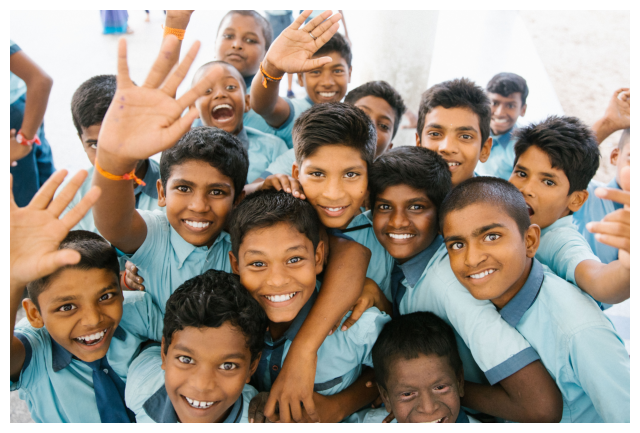

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis("off")
plt.show()

In [6]:
# create the detector and find the faces !

face_detection = FaceDetector().to(device, dtype)

with torch.no_grad():

    dets = face_detection(img)


# to decode later the detections
print(dets, len(dets[0]), len(dets[0][0]))
dets = [FaceDetectorResult(o) for o in dets[0]]
print(dets)

[tensor([[ 6.5652e+02,  5.8410e+02,  8.4608e+02,  ...,  7.8510e+02,
          7.4430e+02,  9.5480e-01],
        [ 2.3254e+03,  3.5028e+02,  2.7465e+03,  ...,  2.6825e+03,
          7.4698e+02,  9.3362e-01],
        [ 1.6349e+03,  1.3682e+02,  2.0478e+03,  ...,  1.9330e+03,
          4.4342e+02,  9.2687e-01],
        ...,
        [ 2.7613e+02, -4.5266e+00,  6.5772e+02,  ...,  4.2268e+02,
          2.8207e+02,  3.0765e-01],
        [ 4.7134e+03,  7.0128e+02,  4.9957e+03,  ...,  4.8994e+03,
          8.9484e+02,  3.0692e-01],
        [ 2.0092e+03,  2.0411e+03,  2.0410e+03,  ...,  2.0259e+03,
          2.0664e+03,  3.0316e-01]])] 67 15
[<kornia.contrib.face_detection.FaceDetectorResult object at 0x7f790f3b4290>, <kornia.contrib.face_detection.FaceDetectorResult object at 0x7f790f33ebd0>, <kornia.contrib.face_detection.FaceDetectorResult object at 0x7f790f52e750>, <kornia.contrib.face_detection.FaceDetectorResult object at 0x7f790f52dd10>, <kornia.contrib.face_detection.FaceDetectorResult o

In [139]:
# crop the faces from the original image and apply blurring using the gaussian_blurd2d operator.

# blurring paramters

k: int = 21  # kernel_size

s: float = 35.0  # sigma

def apply_blur_face(img: torch.Tensor, img_vis: np.ndarray, x1, y1, x2, y2):

    # crop the face

    roi = img[..., y1:y2, x1:x2]

    # apply blurring and put back to the visualisation image

    roi = K.filters.gaussian_blur2d(roi, (k, k), (s, s))

    img_vis[y1:y2, x1:x2] = K.tensor_to_image(roi)

5013 3342
[656, 584] [846, 806] 0.954798698425293
[656, 584] [846, 806] 0.954798698425293
[2325, 350] [2746, 754] 0.9336237907409668
[2325, 350] [2746, 754] 0.9336237907409668
[1634, 136] [2047, 551] 0.9268733263015747
[1634, 136] [2047, 551] 0.9268733263015747
[3366, 966] [3832, 1366] 0.920691728591919
[3366, 966] [3832, 1366] 0.920691728591919
[1260, 2579] [1637, 2986] 0.9142814874649048
[1260, 2579] [1637, 2986] 0.9142814874649048
[1460, 1232] [1852, 1672] 0.9138974547386169
[1460, 1232] [1852, 1672] 0.9138974547386169
[1486, 520] [1912, 948] 0.90372633934021
[1486, 520] [1912, 948] 0.90372633934021
[1834, 1867] [2270, 2288] 0.8938018679618835
[1834, 1867] [2270, 2288] 0.8938018679618835
[3300, 760] [3753, 1142] 0.8819179534912109
[3300, 760] [3753, 1142] 0.8819179534912109
[2833, 729] [3128, 1167] 0.8796189427375793
[2833, 729] [3128, 1167] 0.8796189427375793
[2474, 1102] [2915, 1546] 0.875763475894928
[2474, 1102] [2915, 1546] 0.875763475894928
[1253, 1240] [1627, 1669] 0.86530774

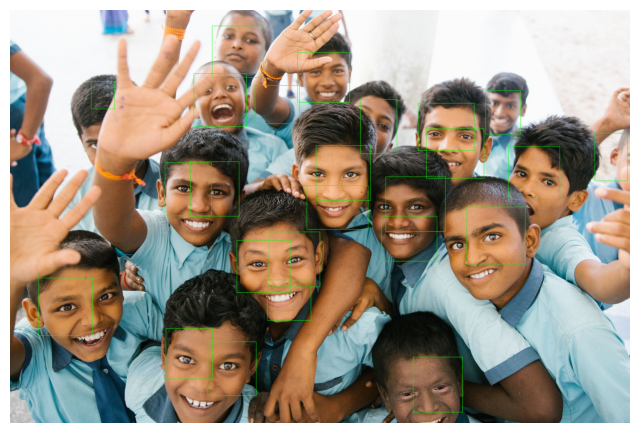

In [8]:
y_max, x_max, _ = img_vis.shape
img_vis_new = img_vis
print(x_max, y_max)
for b in dets:

    # draw face bounding box around each detected face
    tp = b.top_left.int().tolist()
    br = b.bottom_right.int().tolist()
    score = b.score.tolist()
    x1, y1 = tp

    x2, y2 = br
    print(tp, br, score)
    
    if x1 < 0 or x2 < 0 or y1 < 0 or y2 < 0:
        continue
    if x1 > x_max or x2 > x_max or y1 > y_max or y2 > y_max:
        continue
    if x2 - x1 < 10 or y2 - y1 < 10:
        continue
    if score < 0.7:
        continue  # skip detection with low score

    print(tp, br, score)

    img_vis_new = cv2.rectangle(img_vis_new, (x1, y1), (x2, y2), (0, 255, 0), 2)


    # blur the detected faces

    #apply_blur_face(img, img_vis_new, x1, y1, x2, y2)

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis("off")
plt.show()

In [9]:
# create the detector and find the faces !

face_detection = FaceDetector().to(device, dtype)


with torch.no_grad():

    dets = face_detection(img)


# to decode later the detections

dets = [FaceDetectorResult(o) for o in dets]

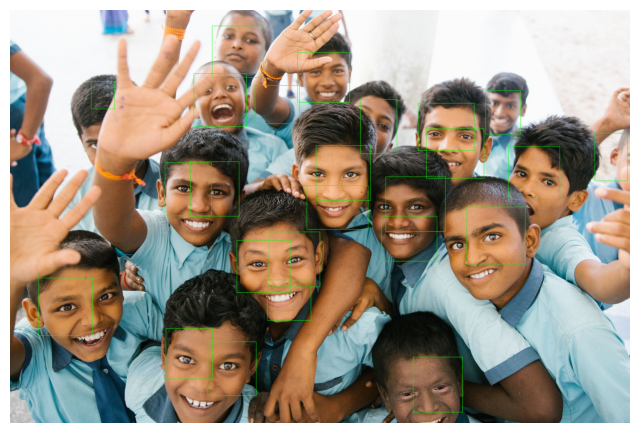

In [11]:
# load the image (face detector expects a image in rage 0-255 (8 bits))

img = K.io.load_image("church-of-the-king.jpg", K.io.ImageLoadType.RGB8, device=device)[None, ...].to(dtype=dtype)  # BxCxHxW

img_vis = K.tensor_to_image(img.byte())  # to later visualize

# create the detector and find the faces !

face_detection = FaceDetector().to(device, dtype)


with torch.no_grad():

    dets = face_detection(img)


# to decode later the detections

dets = [FaceDetectorResult(o) for o in dets]

for b in dets:

    # draw face bounding box around each detected face

    top_left = b.top_left.int().tolist()

    bottom_right = b.bottom_right.int().tolist()

    scores = b.score.tolist()


    for score, tp, br in zip(scores, top_left, bottom_right):

        x1, y1 = tp

        x2, y2 = br


        if score < 0.7:

            continue  # skip detection with low score

        img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)


        # blur the detected faces

        #apply_blur_face(img, img_vis, x1, y1, x2, y2)


plt.figure(figsize=(8, 8))

plt.imshow(img_vis)

plt.axis("off")

plt.show()

In [13]:
import cv2
import torch
import kornia as K

# Load the image
img = K.io.load_image("church-of-the-king.jpg", K.io.ImageLoadType.RGB8, device=device)[None, ...].to(dtype=dtype)  # BxCxHxW
img_vis = K.tensor_to_image(img.byte())  # To visualize

# Create the face detector
face_detection = FaceDetector().to(device, dtype)

# Perform face detection
with torch.no_grad():
    dets = face_detection(img)

# Decode the detections
dets = [FaceDetectorResult(o) for o in dets]

# Draw bounding boxes and save detected faces
for b, idx in zip(dets, range(len(dets))):
    top_left = b.top_left.int().tolist()
    bottom_right = b.bottom_right.int().tolist()
    scores = b.score.tolist()

    for score, tp, br in zip(scores, top_left, bottom_right):
        x1, y1 = tp
        x2, y2 = br

        if score < 0.7:
            continue  # Skip detection with low score

        # Draw bounding box on the visualization image
        img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Save the detected face as a separate image
        face_image = img[:, :, y1:y2, x1:x2]  # Crop the face region
        face_image = K.tensor_to_image(face_image.byte())  # Convert back to image format

        # Save the face image with an index as the filename
        face_filename = f"detected_face_{idx}.jpg"
        cv2.imwrite(face_filename, face_image)

# Save the visualization image with bounding boxes
cv2.imwrite("detected_faces.jpg", img_vis)


True

In [56]:
import os
import cv2
import torch
import kornia as K

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

def detect_and_save_faces(image_folder, output_folder):

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Create the face detector
    face_detection = FaceDetector().to(device, dtype)

    # Load and process each image in the folder
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        # Load the image
        image_path = os.path.join(image_folder, image_file)
        img = K.io.load_image(image_path, K.io.ImageLoadType.RGB8, device=device)[None, ...].to(dtype=dtype)  # BxCxHxW
        img_vis = K.tensor_to_image(img.byte())  # To visualize

        # Perform face detection
        with torch.no_grad():
            dets = face_detection(img)

        # Decode the detections
        dets = FaceDetectorResult([dets])

        # Save the faces with bounding boxes
        for b in dets:
            top_left = b.top_left.int().tolist()
            bottom_right = b.bottom_right.int().tolist()
            scores = b.score.tolist()
            print(type(top_left))
            print(type(bottom_right))
            print(type(scores))
            for score, tp, br in zip(scores, top_left, bottom_right):
                x1, y1 = tp
                x2, y2 = br

                if score < 0.7:
                    continue  # Skip detection with low score

                # Draw bounding box on the visualization image
                img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Save the face region as a separate image
                face_image = img[:, :, y1:y2, x1:x2]  # Crop the face region
                face_image = K.tensor_to_image(face_image.byte())  # Convert back to image format

                # Convert the face image from RGB to BGR
                face_image_bgr = cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR)

                # Generate a unique filename for the face image based on coordinates
                face_filename = f"face_{x1}_{y1}_{x2}_{y2}.jpg"
                output_path = os.path.join(output_folder, face_filename)
                cv2.imwrite(output_path, face_image_bgr)

        # Save the visualization image with bounding boxes
        output_vis_path = os.path.join(output_folder, f"detected_faces_{image_file}")
        cv2.imwrite(output_vis_path, img_vis)

# Example usage
detect_and_save_faces("images", "faces")


AttributeError: 'list' object has no attribute 'shape'

In [54]:
for b in dets:
    print(score)

0.30397748947143555
